**İsim: Abdullah Berkay Bayındır**

**ID: 191201053**

**Ders: BIL 470**

In [1]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score

from itertools import cycle

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from dt import DecisionTreeClassifier
from dt import Node

# 1. Exploratory Data Analysis (EDA)

## 1.a. Veri Setinin Okunması

Veri setinin .csv uzantılı dosyadan çekilmesi aşağıdaki satırda yapılmıştır. İkinci okuma ise "*pair plots*" çizimi için ileriki aşamalarda kullanılacaktır.

In [3]:
iris_veri = pd.read_csv("Iris.csv");
iris_veri_pp = pd.read_csv("Iris.csv");

Veri setinin analizine başlanmadan önce ilk sütundaki Id bilgisi ve son sütünda "*string*" tipinde bulunan çiçek türleri sırayla "0,1,2" olarak düzenlenmiştir. 

In [4]:
iris_veri = iris_veri.drop(labels="Id", axis=1);
iris_veri_pp = iris_veri_pp.drop(labels="Id", axis=1);
spc = {'Iris-setosa': 0,'Iris-versicolor': 1,'Iris-virginica': 2}
iris_veri["Species"] = [spc[item] for item in iris_veri["Species"]];

## 1.b. Veri Setinin Özeti

Yapılan değişiklikler sonucunda veri seti aşağıdaki gibi gözükmektedir. Aşağıdaki tablo incelendiğinde 150 verinin ve her bir verinin 4 öz niteliğinin bulunduğu görülmektedir. Buna ek olarak "Species" başlığı altında etiketleri gözükmektedir.

In [5]:
display(iris_veri);

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


Her bir öznitelik verisinin istatistiksel analizi aşağıdaki gibidir. Bu aşamada sırasıyla her bir öznitelikten kaç tane bulunduğu, ortalaması, standart sapması, minimum değeri, maksimum değeri ve belli oranları görülebilmektedir.

In [6]:
sl = iris_veri["SepalLengthCm"].describe();
sw = iris_veri["SepalWidthCm"].describe();
pl = iris_veri["PetalLengthCm"].describe();
pw = iris_veri["PetalWidthCm"].describe();

print(sl);
print(sw);
print(pl);
print(pw);

count    150.000000
mean       5.843333
std        0.828066
min        4.300000
25%        5.100000
50%        5.800000
75%        6.400000
max        7.900000
Name: SepalLengthCm, dtype: float64
count    150.000000
mean       3.054000
std        0.433594
min        2.000000
25%        2.800000
50%        3.000000
75%        3.300000
max        4.400000
Name: SepalWidthCm, dtype: float64
count    150.000000
mean       3.758667
std        1.764420
min        1.000000
25%        1.600000
50%        4.350000
75%        5.100000
max        6.900000
Name: PetalLengthCm, dtype: float64
count    150.000000
mean       1.198667
std        0.763161
min        0.100000
25%        0.300000
50%        1.300000
75%        1.800000
max        2.500000
Name: PetalWidthCm, dtype: float64


"*nunique*" metodu kullanılarak her bir öznitelik ve etiket içinde kaç farklı değerin olduğu aşağıdaki kod bloğunda gözlemlenmiştir. Bu metodun çıktısına göre üç farklı tür ve sırasıyla "SepalLength", "SepalWidth", "PetalLength", "PetalWidth" öznitelikleri için 35, 23, 43, 22 farklı değer bulunmaktadır.

In [7]:
uniqueVal = iris_veri.nunique();
print(uniqueVal);

SepalLengthCm    35
SepalWidthCm     23
PetalLengthCm    43
PetalWidthCm     22
Species           3
dtype: int64


Bu adımda veri setinde birbirini tekrar eden verilerin olup olmadığı incelenmiştir. Eğer bu verilerin sayısı çok fazla olsaydı bu veriler silinebilirdi. Ancak hem tekrar eden veri sayısının üç olması hem de her bir türe ait verilerin eşit olması istenildiği için bu veriler silinmemiştir. 

In [8]:
display(iris_veri[iris_veri.duplicated()])
display(iris_veri.duplicated().sum())

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
34,4.9,3.1,1.5,0.1,0
37,4.9,3.1,1.5,0.1,0
142,5.8,2.7,5.1,1.9,2


3

Bu adımda veri setinin dengesi gözlemlenmiştir. Aşağıdaki şekilden görüleceği üzere bütün türlerin sayısı eşittir yani veri seti dengelidir.

C:\Users\Hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


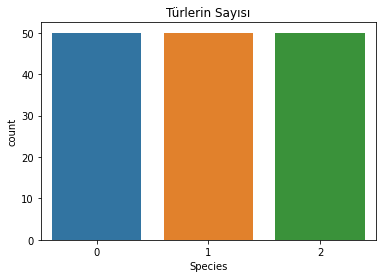

In [9]:
plt.title("Türlerin Sayısı");
sns.countplot(iris_veri["Species"]);

Veri setinde bulunabilecek "*null*" değerler özellikle karar ağacı yönteminde öğrenmede zorluklar çıkaracağı için bu adımda "*null*" değerlerin kontrolü gerçekleştirilmiştir. Eğer "*null*" değerlerin sayısı fazla olsaydı bu değerlerde silinebilirdi ya da uzayda yakınındaki türlere benzer çıktılar verecek şekilde ortalama bir değer verilebilirdi.

In [10]:
display(iris_veri.isnull().sum(axis=0))

SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

## 1.c. Öznitelikler için "*Pair Plots* Çizdirilmesi"

Bu bölümde "*python*"un "*seaborn*" kütüphanesi kullanılarak "*pair plot*"lar çizdirimiştir. "*Pair plot*"lar iki öznitelik arasındaki ilişkiyi anlamak için önemli görsel araçlardır. Buna ek olarak grafik üzerine basit çizgiler çekilerek veri setini ayrıştırmaya da yaramaktadır.

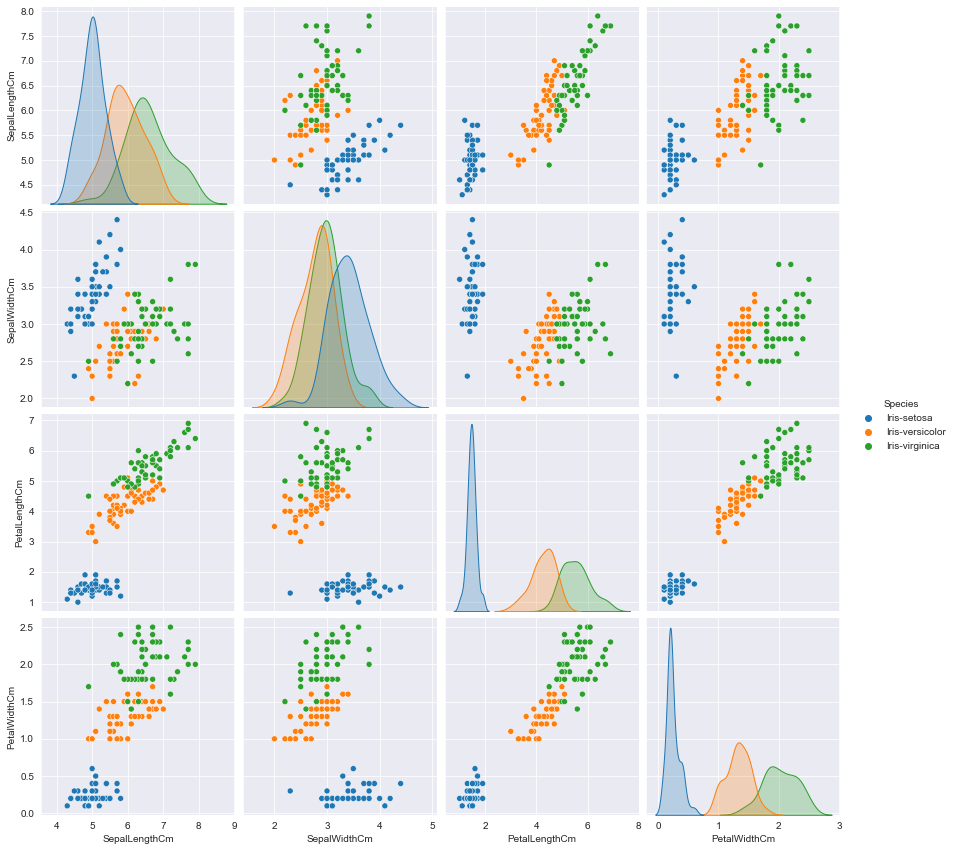

In [11]:
sns.set_style("darkgrid");
sns.pairplot(iris_veri_pp,hue="Species",height = 3);
plt.show();

Farklı öznitelikler için "*pair plot*"lar incelendiğinde "*Iris-Setosa*" isimli türün diğer türlere göre daha kolay ayrıştığı her grafikte görülmektedir. 

## 1.d. Özniteliklerin Korelasyon Matrislerinin Çizdirilmesi

Bu kısımda farklı özniteliklerin ve etiket verisinin arasındaki korelasyon incelenmek için korelasyon matrisi çizdirilmiştir. Matris içindeki veriler eksi bir ile arti bir arasında değişmektedir; renk koyulaştıkça iki özellik arasındaki ilişkinin arttığı, renk açıldıkça iki öznitelik arasındaki ilişkinin azaldığı anlaşılmkatadır.

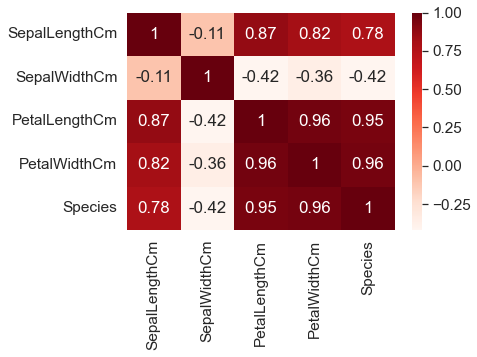

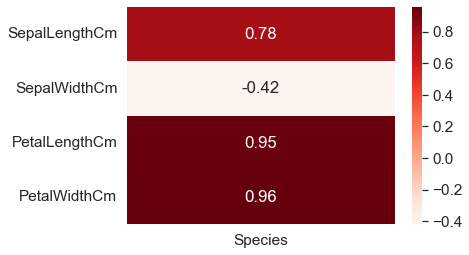

In [12]:
cm = iris_veri.corr();
ft = cm.drop(columns=["SepalLengthCm","SepalWidthCm","PetalLengthCm","PetalWidthCm"]);
ft = ft.drop(labels=["Species"]);

sns.set(font_scale = 1.4);
sns.heatmap(cm, annot=True, cmap=plt.cm.Reds);
plt.show();

sns.set(font_scale = 1.4);
sns.heatmap(ft, annot=True, cmap=plt.cm.Reds);
plt.show();

Bu bölümdeki ilk korelasyon matrisi incelendiğinde "*Petal Length*" ve "*Petal Width*" verilerinin pozitif korelasyon içinde oldukları yani birinin boyu arttıkça diğerinin de boyunun arttığı anlaşılmaktadır. Başka bir taraftan "*Sepal Length*" ve "*Sepal Width*" özniteliklerinin korelasyonları karşılaştırıldığında ters bir korelasyon olduğu görülmektedir. 

# 2. Karar Ağacının İmplemente Edilmesi

Veri setinin etiketlerine bağlı olarak sıralı yapıda verilmiştir. Bu nedenle veri seti işlemlere başlanmadan önce karıştırılmalıdır. Bu işlem aşağıdaki satırda gerçekleştirilmiştir. Eğer karıştırma işlemi yapılmasaydı model bazı türleri öğrenemezdi.

In [13]:
shuffled_iris = iris_veri.sample(frac=1).reset_index(drop=True)
display(shuffled_iris);

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,6.4,3.2,5.3,2.3,2
1,4.6,3.1,1.5,0.2,0
2,7.2,3.2,6.0,1.8,2
3,5.5,3.5,1.3,0.2,0
4,4.5,2.3,1.3,0.3,0
...,...,...,...,...,...
145,6.8,3.2,5.9,2.3,2
146,7.7,3.0,6.1,2.3,2
147,6.1,2.8,4.7,1.2,1
148,5.1,3.8,1.5,0.3,0


In [14]:
x = shuffled_iris.values.tolist()
y = []

for row in x:
    y.append(int(row[4]))
    del row[4]

x = pd.Series(x)
y = pd.Series(y)


X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.2, shuffle = True)

X_train_list = X_train.values.tolist()
X_test_list = X_test.values.tolist()
Y_train_list = Y_train.values.tolist()
Y_test_list = Y_test.values.tolist()



Bu adımda "*phyton*" dosyasında oluşturulan "*DecisionTreeClassifier*" objesi alt satırdaki kod bloğunda oluşturulmuştur. "*Overfit*" gerçekleşmemesi için derinlik argümanı 5 olarak verilmiştir. Sonraki adımda "*classifier*" değişkeni üzerinden işlemler yürütülecektir.

In [15]:
classifier = DecisionTreeClassifier(max_depth=5)

## Sınıflandırıcının Eğitilmesi

Sınıflandırıcı eğitilmesi alt satırdaki kod bloğunda "*fit*" metodu kullanılarak gerçekleştirilmiştir. Argüman olarak da öznitelik ve etiket eğitim setleri verilmiştir.

In [16]:
classifier.fit(X_train_list, Y_train_list)

120
43
77
44
39
5
4
1
33
4
3
1
29


## Test Verilerinin Sınıflarının Tahmin Edilmesi

Antrenman ve eğitim setlerinin tahmini için "*predict*" metodu kullanılmıştır. Bu metod sayesinde eğitim ve antrenman setlerinin çıktıları karşılaştırılmıştır.

In [17]:
predicted_xhat = classifier.predict(X_train_list)
print("Sınıflandırma Sonrası Beklenen Eğitim Verisi Çıktılar")
print(Y_train_list)
print("Tahmin Edilen Eğitim Verisi Çıktıları")
print(predicted_xhat)
print("\n")
predicted_yhat = classifier.predict(X_test_list)
print("Sınıflandırma Sonrası Beklenen Antrenman Verisi Çıktılar")
print(Y_test_list)
print("Tahmin Edilen Antrenman Verisi Çıktıları")
print(predicted_yhat)

Sınıflandırma Sonrası Beklenen Eğitim Verisi Çıktılar
[0, 1, 2, 1, 0, 2, 2, 2, 2, 2, 2, 1, 0, 0, 2, 0, 2, 0, 1, 0, 0, 1, 1, 2, 2, 1, 2, 1, 0, 0, 1, 2, 2, 2, 0, 1, 0, 2, 1, 0, 1, 0, 2, 0, 2, 0, 1, 0, 2, 0, 0, 1, 2, 0, 1, 1, 1, 1, 1, 2, 2, 1, 0, 0, 0, 0, 1, 2, 1, 2, 0, 1, 2, 0, 1, 0, 1, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1, 1, 0, 1, 1, 0, 1, 2, 2, 0, 1, 0, 1, 0, 0, 2, 1, 1, 1, 1, 2, 0, 1, 1, 0, 1, 1]
Tahmin Edilen Eğitim Verisi Çıktıları
[0, 1, 2, 1, 0, 2, 2, 2, 2, 2, 2, 1, 0, 0, 2, 0, 2, 0, 1, 0, 0, 1, 1, 2, 2, 1, 2, 1, 0, 0, 1, 2, 2, 2, 0, 1, 0, 2, 1, 0, 1, 0, 2, 0, 2, 0, 1, 0, 2, 0, 0, 1, 2, 0, 1, 1, 1, 1, 1, 2, 2, 1, 0, 0, 0, 0, 1, 2, 1, 2, 0, 1, 2, 0, 1, 0, 1, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1, 1, 0, 1, 1, 0, 1, 2, 2, 0, 1, 0, 1, 0, 0, 2, 1, 1, 1, 1, 2, 0, 1, 1, 0, 1, 1]


Sınıflandırma Sonrası Beklenen Antrenman Verisi Çıktılar
[2, 2, 1, 0, 2, 0, 0, 2, 0, 0, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 0, 2, 2, 1, 2, 0, 2, 1]
Tahmin Edilen Antrenman Verisi Çıktı

# 3. SONUÇLAR

## Test Verisinin Karmaşıklık Matrisinin İncelenmesi

Veri setlerinin performans ölçümünün yapılması için "*accuracy*" ölçümü her zaman yeterli başarımı sağlayamamaktadır. Bu nedenle "*confusion matrix*" yöntemine ve buradan türetilmiş diğer başarım ölçümü yöntemlerinden olan: precision, recall, F1 skoru ve ROC yöntemleri kullanılmaktadır.

Bu kısımda ilk olarak test verisinin karmaşıklık matrisi incelenmiştir. Karmaşıklık matrisinde veri sınıflandırılması için dört farklı veri bulunmaktadır. Bunlar "*True Positive*", "*True Negative*", "*False Positive*"ve "*False Negative*"dir. Bunlar sırasıyla gerçekten pozitif değerlerin pozitif sınıflandırılması, gerçekten pozitif değerlerin negatif olarak sınıflandırılması, gerçekten negatif değerlerin negatif değer olarak sınıflandırılması ve son olarak gerçekten negatif değerlerin pozitif değer olarak sınıflandırılmasıdır. Satırlar gerçek değerleri gösterirken, sütünlar tahmin edilmiş değerleri temsil etmektedir.

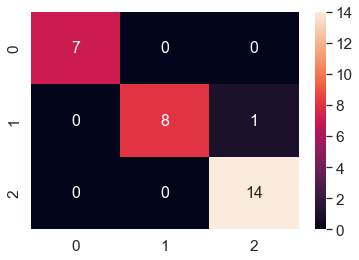

In [18]:
y_pred2 = pd.Series(predicted_yhat)
y_test2 = pd.Series(Y_test_list)
mt = metrics.confusion_matrix(y_test2, y_pred2)
df_cm = pd.DataFrame(mt, range(3), range(3))
sns.set(font_scale = 1.4)
sns.heatmap(df_cm, annot = True, annot_kws = {"size":16})
plt.show()

Karmaşıklık matrisi okunduğunda türler arasında "0" etiketli "*Iris Setosa*" çiçeğinden 14 tane olduğu ve 14'ünün de doğru tahmin edildiği görülmektedir. "1" etiketli "*Iris Versicolor*" 11 tane veri mevcuttur. Ancak bunlardan 10 tanesi doğru tahmin edilmişken bir tanesi "*Iris Virginica*" olarak yanlış sınıflandırılmıştır. Bu durumla bağlantılı olarak toplamda 5 tane "2" etiketli "*Iris Virginica*" türü bulunurken bir tane fazladan bu türden sınıflandırılma yapılmıştır.

## Eğitim Verisinin Karmaşıklık Matrisinin İncelenmesi

Bir önceki adımda test verisine uygulanan performans ölçümü bu seferde eğitim verisinin sonucuna uygulanmıştır.

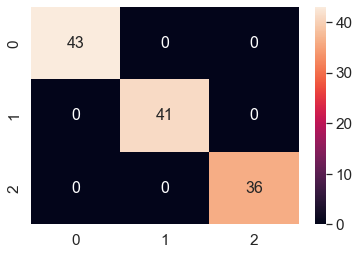

In [19]:
x_pred2 = pd.Series(predicted_xhat)
x_test2 = pd.Series(Y_train_list)
mt = metrics.confusion_matrix(x_test2, x_pred2)
df_cm = pd.DataFrame(mt, range(3), range(3))
sns.set(font_scale = 1.4)
sns.heatmap(df_cm, annot = True, annot_kws = {"size":16})
plt.show()

Matris incelendiğinde modelin başarılı bir şekilde eğitildiği ve %100 tüm verileri doğru sınıflandırdığı görülmektedir. Böyle bir durumda modelin "*overfit*" ettiğinden şüphe duyulabilir ancak. Yukarıdaki karmaşıklık matrisi incelendiğinde test verisinde de yüksek başarı elde etmesinden "*overfit*" olmadığı söylenebilir.

## F1 Skoru

F1 Skoru, "*presicion*" ve "*recall*" performans ölçüm parametrelerinin harmonik ortalamasını alarak bulunmaktadır. Harmonik ortalamanın bir özelliği ortalaması alınan iki değerden küçük olana daha yakın çıkmasıdır. Bu nedenle F1 Skorunun yüksek çıkması için hem "*presicion*" hem de "*recall*" değerlerinin yüksek olması gerekmektedir.
\begin{equation}
F_{1} = \frac{2}{(\frac{1}{R})+(\frac{1}{P})}
\end{equation}

F1 Skoru yukarıdaki denklemdeki gibi hesaplanmaktadır. Bu denklemde R "*recall*" parametresini belirtirken, P "*presicion*" parametresini belirtmektedir.

In [20]:
f2 = metrics.f1_score(x_test2, x_pred2, average = 'weighted')
print("Eğitimin F1 Skoru: ")
print(f2)
print("\n")
f1 = metrics.f1_score(y_test2, y_pred2, average = 'weighted')
print("Testin F1 Skoru: ")
print(f1)

Eğitimin F1 Skoru: 
1.0


Testin F1 Skoru: 
0.9662609871534822


Eğitim ve test verilerinin F1 Skorları ayrı ayrı incelendiğinde ikisinin de bire yakın olduğu görülmektedir. Bu da modelin başarısının yüksek olduğunu kanıtlamaktadır.

## Accuracy

"*Accuracy*" başarım ölçümü için çokça kullanılan parametrelerden biridir. Toplam doğru sınıflandırmaların, toplam vaka sayısına oranı ile bulunmaktadır. Bu yöntemin başarıyı ölçmek için kullanılması bazı durumlarda manipüle edici olabilmektedir. Bunun nedeni bazen "*actual positive*" olarak adlandırılan verinin toplam verinin çok küçük bir kısmını oluşturup doğru sınıflandırılmadığında bile "*accuracy*"nin yüksek çıkabilmesinden dolayı kaynaklanmaktadır.

\begin{equation}
Accuracy = \frac{TP + TN}{TP + TN + FP+ FN}
\end{equation}

Bu parametreyi hesaplamak için kullanılan denklem de yukarıdaki gibidir. TP, TN, FP ve FN sırasıyla "*true positive*", "*true negative*", "*false positive*" ve "*false negative*"e denk gelmektedir.

In [21]:
accuracy1 = metrics.accuracy_score(x_test2, x_pred2)
print("Eğitimin Accuracysi: ")
print(accuracy1)
print("\n")
accuracy2 = metrics.accuracy_score(y_test2, y_pred2)
print("Testin Accuracysi: ")
print(accuracy2)

Eğitimin Accuracysi: 
1.0


Testin Accuracysi: 
0.9666666666666667


Eğitim ve test verilerinin "*Accuracy*"leri ayrı ayrı incelendiğinde ikisinin de bire yakın olduğu görülmektedir. Bu da modelin başarısının yüksek olduğunu kanıtlamaktadır.

## Presicion

"*Presicion*" parametresi, "*confusion matrix*"ten türetilmiş bir parametredir. "*True positive*"lerin, "*true positive*" ve "*false positive*"lerin toplamına oranı ile bulunmaktadır. Sınıflandırılmış pozitif verilerin ne kadar iyi sınıflandırıldığını görmek için kullanılan bir parametredir

\begin{equation}
Presicion = \frac{True Positive}{True Positive + False Positive}
\end{equation}

Yukarıdaki denklemde görüleceği üzere hesaplanmaktadır.

In [22]:
precision1 = metrics.precision_score(x_test2, x_pred2, average = 'weighted')
print("Eğitimin Presicionu: ")
print(precision1)
print("\n")
precision2 = metrics.precision_score(y_test2, y_pred2, average = 'weighted')
print("Testin Presicionu: ")
print(precision2)

Eğitimin Presicionu: 
1.0


Testin Presicionu: 
0.9688888888888889


Test ve eğitim sonucu bire yakın çıkmıştır. Sonucun bire yakın çıkması, pozitif olarak sınıflandırılmış verilerden neredeyse tamamının doğru sınıflandırıldığını yani "*actual positive*" olduğunu göstermektedir.

## Recall

"*Recall*" parametresi de "*confusion matrix*"ten türetilmiş bir parametredir. "*True positive*"lerin, "*true positive*" ve "*false negative*"lerin toplamına oranı ile bulunmaktadır. Gerçekten pozitif olan verilerden ne kadar iyi sınıflandırıldığını görmek için kullanılan bir parametredir.

\begin{equation}
Recall = \frac{True Positive}{True Positive + False Negative}
\end{equation}

Yukarıdaki denklemde görüleceği üzere hesaplanmaktadır.

In [23]:
recall1 = metrics.recall_score(x_test2, x_pred2, average = 'weighted')
print("Eğitimin Recallu: ")
print(recall1)
print("\n")
recall2 = metrics.recall_score(y_test2, y_pred2, average = 'weighted')
print("Testin Recallu: ")
print(recall2)

Eğitimin Recallu: 
1.0


Testin Recallu: 
0.9666666666666667


Test ve eğitim verilerinin "*recall*" sonucu bire yakın çıkmıştır. Sonucun bire yakın çıkması, gerçekten pozitif olan değerlerin iyi bir şekilde sınıflandırıldığını göstermektedir.

## ROC Eğrisinin Çizdirilmesi ve AUC'nin Hesaplanması

ROC "*true positive rate (TPR)*"in, "*false positive rate (FPR)*"e karşı çizdirilmesi ile bulunan bir eğridir. Verilerin her "*cut-off*" değeri için çizdirilmektedir. Bu grafiğin ölçümü ise eğirinin altındaki alanın hesaplanması ile bulunur. Bu alana "*area under curve (AUC)*" de denmektedir ve AUC bire yaklaştıkça sonuç daha iyiye gitmektedir.ROC eğrisi her bölgede incelenerek parametrik bir şekilde TP, TN, FP ve FN değerleri ile oynanmasını sağlamaktadır.

\begin{equation}
TPR = \frac{TP}{TP + FN}
\end{equation}

\begin{equation}
FPR = \frac{FP}{TN + FP}
\end{equation}

Eğrinin eksenlerini belirlemede kullanılan iki formül yukarıda görüldüğü gibidir. Aşağıda ise hem eğitim hem de test verisi için bu eğri çizdirilmiştir. Son olarak ROC'nin ortasında görülmekte olan kesikli çizgi rastgele gerçekleşen bir olayın eğrisini temsil etmektedir. Bu kesikli eğrinin altında kalan durumlarda sınıflandırmanın rastgele bir olaydan kötü gerçekleştiği yorumunu yapmak mümkündür.

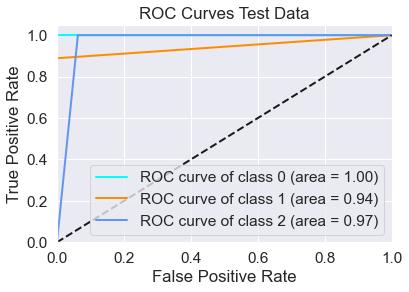

AUC Values of Each Classes ROC Curve are Written on Graph
Macro AUC Value
0.9710648148148148


In [24]:
y_testb = label_binarize(y_test2, classes=[0, 1, 2]);
y_predb = label_binarize(y_pred2, classes=[0, 1, 2]);

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve (y_testb[:,i], y_predb[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))
mean_tpr = np.zeros_like (all_fpr)
for i in range(3):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i]);
mean_tpr /= 3;
fpr ["macro"] = all_fpr
tpr ["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.plot([0,1],[0,1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Test Data")
plt.legend(loc="lower right")
plt.show()
print("AUC Values of Each Classes ROC Curve are Written on Graph")
print("Macro AUC Value")
print(roc_auc["macro"])


Test verisi için eğri incelendiğinde "*Iris Setosa (0)*" türü için AUC bire eşit çıkmıştır. Bu da TP ve FP'lerin birbirinden mükemmel şekilde ayrılması ile olmuştur. "*Iris Setosa*"nın mükemmel olarak ayrılabileceği önceki "*pair plots*" çiziminde de açıkça gözükmektedir. Diğer iki türe gelecek olursa onlarda mükemmele yakın bir şekilde ayrılabilmiştir. Bunu AUC değerlerinden anlamak mümkündür.

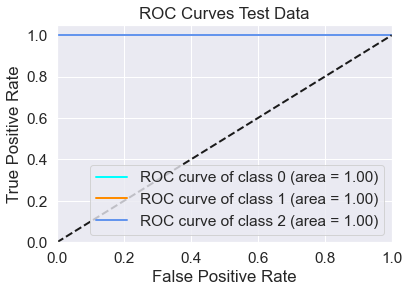

AUC Values of Each Classes ROC Curve are Written on Graph
Macro AUC Value
1.0


In [25]:
x_testb = label_binarize(x_test2, classes=[0, 1, 2]);
x_predb = label_binarize(x_pred2, classes=[0, 1, 2]);

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve (x_testb[:,i], x_predb[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))
mean_tpr = np.zeros_like (all_fpr)
for i in range(3):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i]);
mean_tpr /= 3;
fpr ["macro"] = all_fpr
tpr ["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.plot([0,1],[0,1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Test Data")
plt.legend(loc="lower right")
plt.show()
print("AUC Values of Each Classes ROC Curve are Written on Graph")
print("Macro AUC Value")
print(roc_auc["macro"])

Eğitim verisinin AUC'ünün tüm türler için 1'e eşit olması yine eğitim sınıflandırmasının çok iyi gerçekleştiğini göstermektedir.